# Pluck Points from Lat/Lon Grid

This builds on my example from

- Stack Overflow: https://stackoverflow.com/questions/58758480/xarray-select-nearest-lat-lon-with-multi-dimension-coordinates

- MetPy Details: https://unidata.github.io/MetPy/latest/tutorials/xarray_tutorial.html?highlight=assign_y_x

In [ ]:
from herbie.archive import Herbie
from metpy.units import units
import matplotlib.pyplot as plt
from toolbox.cartopy_tools import pc, common_features, ccrs
import numpy as np
import xarray as xr
from shapely.geometry import MultiPoint
from toolbox.gridded_data import pluck_points

In [1]:
H = Herbie('2021-9-23')
ds = H.xarray('TMP:2 m')

NameError: name 'Herbie' is not defined

In [ ]:
def nearest_points(ds, points, names=None, verbose=True):
    """
    Pluck the nearest latitude/longitude points from a model grid.

    Info
    ----
    - Stack Overflow: https://stackoverflow.com/questions/58758480/xarray-select-nearest-lat-lon-with-multi-dimension-coordinates
    - MetPy Details: https://unidata.github.io/MetPy/latest/tutorials/xarray_tutorial.html?highlight=assign_y_x

    Parameters
    ----------
    ds : a friendly xarray Dataset
    points : tuple (lon, lat) or list of tuples
        The longitude and latitude (lon, lat) coordinate pair (as a tuple)
        for the points you want to pluck from the gridded Dataset. 
        A list of tuples may be given to return the values from multiple points.
    names : list
        A list of names for each point location (i.e., station name).
        None will not append any names. names should be the same
        length as points.
    """
    
    # Check if MetPy has already parsed the CF metadata grid projection.
    # Do that if it hasn't been done yet.
    if 'metpy_crs' not in ds:
        ds = ds.metpy.parse_cf()

    # Apply the MetPy method `assign_y_x` to the dataset
    # https://unidata.github.io/MetPy/latest/api/generated/metpy.xarray.html?highlight=assign_y_x#metpy.xarray.MetPyDataArrayAccessor.assign_y_x
    ds = ds.metpy.assign_y_x()

    # Convert the requested [(lon,lat), (lon,lat)] points to map projection.
    # Accept a list of point tuples, or Shapely Points object.
    # We want to index the dataset at a single point.
    # We can do this by transforming a lat/lon point to the grid location
    crs = ds.metpy_crs.item().to_cartopy()
    # lat/lon input must be a numpy array, not a list or polygon
    if isinstance(points, tuple):
        # If a tuple is give, turn into a one-item list.
        points = np.array([points])
    if not isinstance(points, np.ndarray):
        # Points must be a 2D numpy array
        points = np.array(points)
    lons = points[:,0]
    lats = points[:,1]
    transformed_data = crs.transform_points(ccrs.PlateCarree(), lons, lats)
    xs = transformed_data[:,0]
    ys = transformed_data[:,1]

    # Select the nearest points from the projection coordinates.
    # TODO: Is there a better way?
    # There doesn't seem to be a way to get just the points like this
    #ds = ds.sel(x=xs, y=ys, method='nearest')
    # because it gives a 2D array, and not a point-by-point index.
    # Instead, I have too loop the ds.sel method
    new_ds = xr.concat([ds.sel(x=xi, y=yi, method='nearest') for xi, yi in zip(xs, ys)], dim='point')

    # Add list of names as a coordinate    
    if names is not None:
        # Assign the point dimension as the names.
        assert len(points) == len(names), '`points` and `names` must be same length.'
        new_ds['point'] = names

    return new_ds

In [ ]:
points = [(-114,45),(-115,45),(-116,45),(-117,45),(-118,45)]
names = ['hi', 'by', 'a', 'b', 'c']
dsp = nearest_points(ds, points, names)

dsp

In [ ]:
pluck_points(ds, (-115, 45))

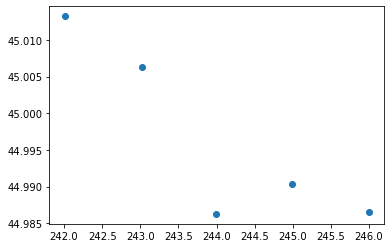

In [6]:
plt.scatter(dsp.longitude, dsp.latitude)

In [7]:
dspp = pluck_points(ds, points, names=names)
dspp

<xarray.Dataset>
Dimensions:              (point: 5)
Coordinates:
    time                 datetime64[ns] 2021-09-23
    step                 timedelta64[ns] 00:00:00
    heightAboveGround    float64 2.0
    latitude             (point) float64 45.01 44.99 44.99 45.01 45.01
    longitude            (point) float64 -114.0 -115.0 -116.0 -117.0 -118.0
    valid_time           datetime64[ns] 2021-09-23
    distance             (point) float64 1.606e+03 1.169e+03 ... 1.539e+03
  * point                (point) <U2 'hi' 'by' 'a' 'b' 'c'
Data variables:
    t2m                  (point) float32 293.5 292.0 287.0 289.5 293.3
    gribfile_projection  (point) object None None None None None
Attributes: (12/13)
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP 
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP 
    ...                      ...
    product:                 sfc
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              /p/cwfs/blaylock/data/hrrr/20210923/hrrr.t00z.wr...
    x_index:                 [466, 440, 414, 389, 363]
    y_index:                 [810, 814, 819, 825, 831]

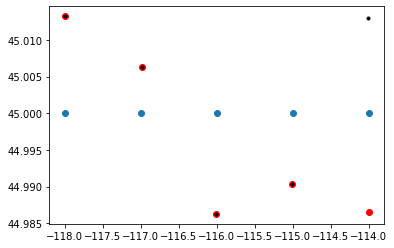

In [8]:
plt.scatter(dsp.longitude-360, dsp.latitude, color='r')
plt.scatter(dspp.longitude, dspp.latitude, marker='.', color='k')
plt.scatter(np.array(points)[:,0], np.array(points)[:,1])

In [66]:
points = np.array([(-100,45), (-100.08, 45.05)])
names = ['hi', 'by']
dsp = nearest_points(ds, points, names)


/p/home/blaylock/anaconda3/envs/herbie/lib/python3.8/site-packages/metpy/xarray.py:349: UserWarning: More than one time coordinate present for variable "gribfile_projection".
  warnings.warn('More than one ' + axis + ' coordinate present for variable'
/p/home/blaylock/anaconda3/envs/herbie/lib/python3.8/site-packages/metpy/xarray.py:349: UserWarning: More than one time coordinate present for variable "t2m".
  warnings.warn('More than one ' + axis + ' coordinate present for variable'
/p/home/blaylock/anaconda3/envs/herbie/lib/python3.8/site-packages/metpy/xarray.py:349: UserWarning: More than one time coordinate present for variable "gribfile_projection".
  warnings.warn('More than one ' + axis + ' coordinate present for variable'


/p/home/blaylock/anaconda3/envs/herbie/lib/python3.8/site-packages/metpy/xarray.py:349: UserWarning: More than one time coordinate present for variable "gribfile_projection".
  warnings.warn('More than one ' + axis + ' coordinate present for variable'
/p/home/blaylock/anaconda3/envs/herbie/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


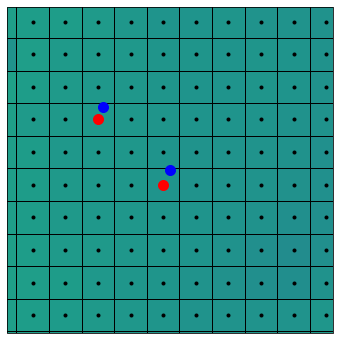

In [65]:
crs = ds.metpy.parse_cf().t2m.metpy.cartopy_crs

ax = common_features(crs=crs, figsize=[6,6]).STATES().ax
ax.center_extent(lat=45, lon=-100, pad=15000);

# Raw Grid
ax.pcolormesh(ds.longitude, ds.latitude, ds.t2m, transform=pc, edgecolors='k')
ax.scatter(ds.longitude, ds.latitude, transform=pc, color='k', marker='.')

# Requested Point
ax.scatter(points[:,0], points[:,1], transform=pc, color='b', s=100)

# Nearest Point
ax.scatter(dsp.longitude, dsp.latitude, transform=pc, color='r', s=100)

#plt.legend()

In [ ]:
points = np.array([(-100,45), (-100.08, 45.05)])
names = ['hi', 'by']

In [67]:
%%timeit
dsp = nearest_points(ds, points, names)

/p/home/blaylock/anaconda3/envs/herbie/lib/python3.8/site-packages/metpy/xarray.py:349: UserWarning: More than one time coordinate present for variable "gribfile_projection".
  warnings.warn('More than one ' + axis + ' coordinate present for variable'
/p/home/blaylock/anaconda3/envs/herbie/lib/python3.8/site-packages/metpy/xarray.py:349: UserWarning: More than one time coordinate present for variable "t2m".
  warnings.warn('More than one ' + axis + ' coordinate present for variable'
/p/home/blaylock/anaconda3/envs/herbie/lib/python3.8/site-packages/metpy/xarray.py:349: UserWarning: More than one time coordinate present for variable "gribfile_projection".
  warnings.warn('More than one ' + axis + ' coordinate present for variable'
/p/home/blaylock/anaconda3/envs/herbie/lib/python3.8/site-packages/metpy/xarray.py:349: UserWarning: More than one time coordinate present for variable "gribfile_projection".
  warnings.warn('More than one ' + axis + ' coordinate present for variable'
/p/home/

501 ms ± 15.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [68]:
%%timeit
dspp = pluck_points(ds, points, names)

119 ms ± 604 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [81]:
from synoptic.services import stations_nearesttime, stations_metadata
from datetime import datetime

In [133]:
a = stations_metadata(radius='UKBKB,60')


 🚚💨 Speedy Delivery from Synoptic API [metadata]: https://api.synopticdata.com/v2/stations/metadata?radius=UKBKB,60&token=🙈HIDDEN



In [134]:
points = np.array(list(zip(a.loc['longitude'], a.loc['latitude'])))
names = a.loc['STID'].to_list()
#points, names

In [126]:
%%time
a = 5

CPU times: user 285 µs, sys: 17 µs, total: 302 µs
Wall time: 1.77 ms


In [137]:
%%time
dspp = pluck_points(ds, points, names)

CPU times: user 1min 52s, sys: 3.17 s, total: 1min 55s
Wall time: 1min 56s


In [135]:
%%time
dsp = nearest_points(ds, points, names)

/p/home/blaylock/anaconda3/envs/herbie/lib/python3.8/site-packages/metpy/xarray.py:349: UserWarning: More than one time coordinate present for variable "gribfile_projection".
  warnings.warn('More than one ' + axis + ' coordinate present for variable'
/p/home/blaylock/anaconda3/envs/herbie/lib/python3.8/site-packages/metpy/xarray.py:349: UserWarning: More than one time coordinate present for variable "t2m".
  warnings.warn('More than one ' + axis + ' coordinate present for variable'
/p/home/blaylock/anaconda3/envs/herbie/lib/python3.8/site-packages/metpy/xarray.py:349: UserWarning: More than one time coordinate present for variable "gribfile_projection".
  warnings.warn('More than one ' + axis + ' coordinate present for variable'


CPU times: user 6.53 s, sys: 884 ms, total: 7.41 s
Wall time: 7.5 s


In [136]:
dsp

<xarray.Dataset>
Dimensions:              (point: 1948)
Coordinates:
    time                 datetime64[ns] 2021-09-23
    step                 timedelta64[ns] 00:00:00
    heightAboveGround    float64 2.0
    latitude             (point) float64 40.75 40.56 40.67 ... 40.65 40.45 40.56
    longitude            (point) float64 -111.8 -111.9 -111.8 ... -111.7 -112.3
    valid_time           datetime64[ns] 2021-09-23
    metpy_crs            object Projection: lambert_conformal_conic
    y                    (point) float64 3.447e+05 3.237e+05 ... 3.297e+05
    x                    (point) float64 -1.204e+06 -1.21e+06 ... -1.249e+06
  * point                (point) <U9 'WBB' 'SNHUT' 'HOL' ... 'UTAFC' 'UT112'
Data variables:
    t2m                  (point) float32 298.4 300.5 299.0 ... 298.1 292.9 295.5
    gribfile_projection  (point) object None None None None ... None None None
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP 
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP 
    model:                   hrrr
    product:                 sfc
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              /p/cwfs/blaylock/data/hrrr/20210923/hrrr.t00z.wr...

In [132]:
dspp

<xarray.Dataset>
Dimensions:              (point: 244)
Coordinates:
    time                 datetime64[ns] 2021-09-23
    step                 timedelta64[ns] 00:00:00
    heightAboveGround    float64 2.0
    latitude             (point) float64 40.32 40.22 40.38 ... 40.18 40.03 40.33
    longitude            (point) float64 -111.6 -111.7 -111.6 ... -111.5 -111.5
    valid_time           datetime64[ns] 2021-09-23
    distance             (point) float64 1.239e+03 909.3 ... 1.566e+03 1.293e+03
  * point                (point) <U9 'CRM' 'KPVU' 'SND' ... 'UR615' 'PC068'
Data variables:
    t2m                  (point) float32 291.7 300.2 295.1 ... 299.4 297.4 296.2
    gribfile_projection  (point) object None None None None ... None None None
Attributes: (12/13)
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP 
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP 
    ...                      ...
    product:                 sfc
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              /p/cwfs/blaylock/data/hrrr/20210923/hrrr.t00z.wr...
    x_index:                 [503, 498, 503, 503, 499, 500, 500, 501, 500, 49...
    y_index:                 [627, 624, 629, 629, 628, 625, 626, 622, 624, 62...

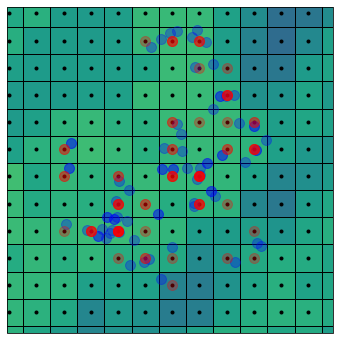

In [104]:
ax = common_features(crs=crs, figsize=[6,6]).STATES().ax
ax.center_extent(lon=points[:,0].mean(), lat=points[:,1].mean(),  pad=18000);

# Raw Grid
ax.pcolormesh(ds.longitude, ds.latitude, ds.t2m, transform=pc, edgecolors='k')
ax.scatter(ds.longitude, ds.latitude, transform=pc, color='k', marker='.')

# Requested Point
ax.scatter(points[:,0], points[:,1], transform=pc, color='b', s=100, alpha=.3)

# Nearest Point
ax.scatter(dsp.longitude, dsp.latitude, transform=pc, color='r', s=100, alpha=.3)

#plt.legend()

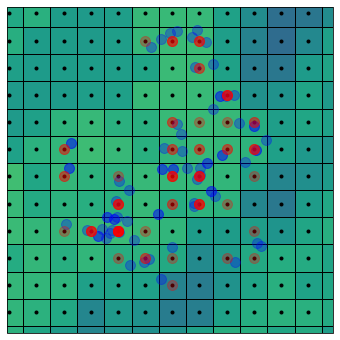

In [105]:
ax = common_features(crs=crs, figsize=[6,6]).STATES().ax
ax.center_extent(lon=points[:,0].mean(), lat=points[:,1].mean(),  pad=18000);

# Raw Grid
ax.pcolormesh(ds.longitude, ds.latitude, ds.t2m, transform=pc, edgecolors='k')
ax.scatter(ds.longitude, ds.latitude, transform=pc, color='k', marker='.')

# Requested Point
ax.scatter(points[:,0], points[:,1], transform=pc, color='b', s=100, alpha=.3)

# Nearest Point
ax.scatter(dspp.longitude, dspp.latitude, transform=pc, color='r', s=100, alpha=.3)

#plt.legend()

In [110]:
dspp.longitude-dsp.longitude

<xarray.DataArray 'longitude' (point: 75)>
array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.0054269 ,  0.        ,  0.        ,  0.        ,
        0.00536663,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.03482097,  0.03482097,
       -0.0053924 , -0.0053924 ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.00542279,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.03489358,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])
Coordinates:
    time               datetime64[ns] 2021-09-23
    step               timedelta64[ns] 00:00:00
    heightAboveGround  float64 2.0
    valid_time         datetime64[ns] 2021-09-23
    distance           (point) float64 909.3 126.1 1.167e+03 ... 759.6 1.566e+03
  * point              (point) <U9 'KPVU' 'QSV' 'QU2' ... 'KSPK' 'UR613' 'UR615'
    metpy_crs          object Projection: lambert_conformal_conic
    y                  (point) float64 2.847e+05 2.787e+05 ... 2.607e+05
    x                  (point) float64 -1.204e+06 -1.195e+06 ... -1.192e+06

In [109]:
dspp.latitude-dsp.latitude

<xarray.DataArray 'latitude' (point: 75)>
array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.02664679,  0.        ,  0.        ,  0.        ,
       -0.02665374,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.00413701,  0.00413701,
        0.02665073,  0.02665073,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.02664737,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.00412436,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])
Coordinates:
    time               datetime64[ns] 2021-09-23
    step               timedelta64[ns] 00:00:00
    heightAboveGround  float64 2.0
    valid_time         datetime64[ns] 2021-09-23
    distance           (point) float64 909.3 126.1 1.167e+03 ... 759.6 1.566e+03
  * point              (point) <U9 'KPVU' 'QSV' 'QU2' ... 'KSPK' 'UR613' 'UR615'
    metpy_crs          object Projection: lambert_conformal_conic
    y                  (point) float64 2.847e+05 2.787e+05 ... 2.607e+05
    x                  (point) float64 -1.204e+06 -1.195e+06 ... -1.192e+06

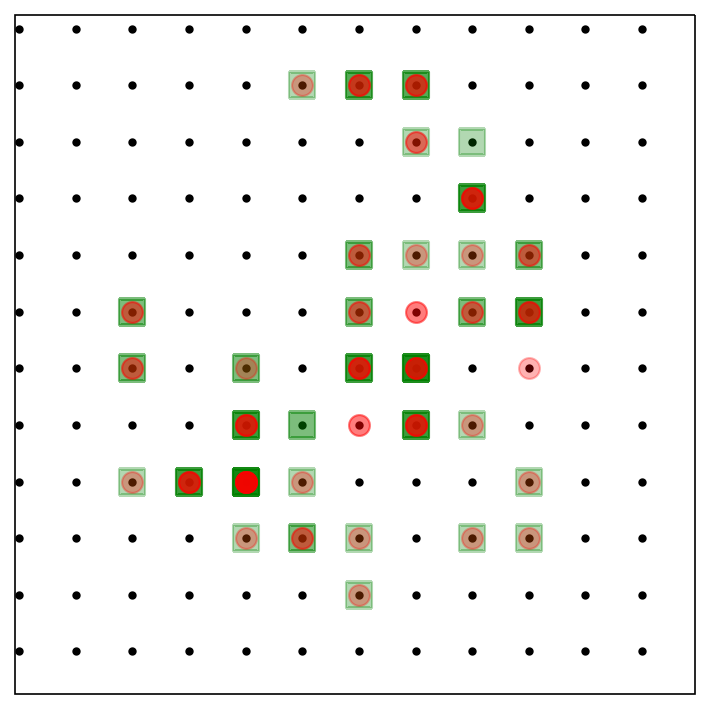

In [114]:
ax = common_features(crs=crs, figsize=[6,6], dpi=150).STATES().ax
ax.center_extent(lon=points[:,0].mean(), lat=points[:,1].mean(),  pad=18000);

# Raw Grid
ax.scatter(ds.longitude, ds.latitude, transform=pc, color='k', marker='.')

# Nearest Point
ax.scatter(dsp.longitude, dsp.latitude, transform=pc, color='g', marker='s', s=150, alpha=.3)
ax.scatter(dspp.longitude, dspp.latitude, transform=pc, color='r', s=100, alpha=.3)

#plt.legend()